In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
inputImg = cv2.imread('testingPic.jpg')
frame = cv2.blur(inputImg,(9,9))

In [3]:
goal = [900, 50]

TLowPos = (75,175,115)
THighPos = (90,190,120)

TLowDir = (200, 100, 30)
THighDir = (255, 120, 50)

TLowObs = (0,0,150)
THighObs = (100,100,255)

SE = np.array([[0,0,1,0,0],
               [0,1,1,1,0],
               [1,1,1,1,1],
               [0,1,1,1,0],
               [0,0,1,0,0]], 'uint8')

In [4]:
def odoFetch():
    maskPos = cv2.inRange(frame, TLowPos, THighPos)
    maskDir = cv2.inRange(frame, TLowDir, THighDir)

    _, _, _, pos = cv2.connectedComponentsWithStats(maskPos, connectivity=8)
    _, _, _, pointDir = cv2.connectedComponentsWithStats(maskDir, connectivity=8)
    
    pos = np.rint(pos[1]).astype(np.int32)
    pointDir = np.rint(pointDir[1]).astype(np.int32)
    print(pos)
    
    angle = math.atan2(pointDir[1]-pos[1], pointDir[0]-pos[0])

    odometry = np.append(pos,angle)
    
    return odometry

In [5]:
def mapFetch():
    maskObs = cv2.inRange(frame, TLowObs, THighObs)
    maskObsDilated = cv2.dilate(maskObs, SE, iterations = 30)
    maskObsMargin = cv2.dilate(maskObsDilated, SE, iterations = 5)

    dst = cv2.cornerHarris(maskObsMargin,20,3,0.04)
    blobCorner = np.zeros(frame.shape[:2], 'uint8')
    blobCorner[dst>0.04*dst.max()]=1

    _, _, _, nodes = cv2.connectedComponentsWithStats(blobCorner, connectivity=8)

    nodes = np.append(nodes, [odo[:2]], axis = 0)
    nodes = np.append(nodes, [goal], axis = 0)
    nodes = np.rint(nodes[1:]).astype(np.int32)

    linkMat = np.ones((nodes.shape[0], nodes.shape[0]))

    for i in range(nodes.shape[0]):
        for j in range(i+1, nodes.shape[0]):
            rangeYbigger = abs(nodes[i,1]-nodes[j,1]) > abs(nodes[i,0]-nodes[j,0])

            if ((rangeYbigger and (nodes[i,1] > nodes[j,1])) or (not(rangeYbigger) and (nodes[i,0] > nodes[j,0]))):
                node1, node2 =  nodes[j,:], nodes[i,:]
            else:
                node1, node2 =  nodes[i,:], nodes[j,:]

            if rangeYbigger:
                alpha = (node2[0]-node1[0])/(node2[1]-node1[1])
                for y in range(node2[1]-node1[1]):
                    if (maskObsDilated[y+node1[1], round(alpha*y)+node1[0]] > 0):
                        linkMat[j, i] = 0
                        break

            elif not(rangeYbigger):
                alpha = (node2[1]-node1[1])/(node2[0]-node1[0])
                for x in range(node2[0]-node1[0]):
                    if (maskObsDilated[round(alpha*x)+node1[1], x+node1[0]] > 0):
                        linkMat[j, i] = 0
                        break

    linkMat = np.nonzero(np.tril(linkMat, k=-1))
    nodeCon = np.array(linkMat).T
    
    return nodes, nodeCon, maskObs, maskObsDilated

In [10]:
def mapDisp():
    blackImage = np.zeros(frame.shape, 'uint8')
    whiteImage = 255*np.ones(frame.shape, 'uint8')

    obstacles = cv2.bitwise_and(whiteImage, whiteImage, mask=maskObs)
    safeZone = cv2.bitwise_and(whiteImage, whiteImage, mask=maskObsDilated)
    terrain = cv2.addWeighted(safeZone,0.2,obstacles,0.4,0)

    for idx, node in enumerate(nodes):
        output = cv2.circle(terrain, node, 5, (255, 0, 0), -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        output = cv2.putText(output, str(idx), node, font, 2,(255,255,255),2,cv2.LINE_AA)

    for con in nodeCon:
        output = cv2.line(terrain, nodes[con[0]], nodes[con[1]], (50,150,150), 1)
        
    pos = np.rint(odo[:2]).astype(np.int32)
    angle = odo[2]
    output = cv2.circle(output, pos, 10, (0, 255, 0), -1)
    output = cv2.circle(output, goal, 10, (0, 255, 255), -1)
    output = cv2.line(output, pos, (pos + np.rint([40*math.cos(angle), 40*math.sin(angle)]).astype(np.int32)), (50,150,150), 3)
    
    plt.imshow(output)
    return




[ 268 1053]


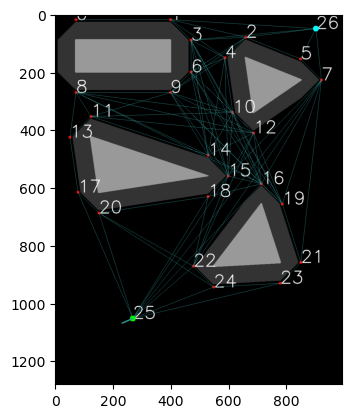

In [11]:
# odo : (x, y, angle) odometry of the robot
# nodes : (x, y) array of position for each node
# nodeCon : (idxNode1, idxNode2) array of link between all the nodes

odo = odoFetch()
nodes, nodeCon, maskObs, maskObsDilated = mapFetch()
mapDisp()

In [ ]:
print